#Разведочный анализ данных
#Импортируем библиотеки

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from pandas.plotting import scatter_matrix
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,)
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
%matplotlib inline 

Data extraction - загружаем датасет

In [68]:
X_full = pd.read_csv('/Users/levashev/Desktop/METABRIC_RNA_Mutation.csv', low_memory=False)

Трансформируем датасет с целью упрощения работы с ним. Отсеиваем генетические признаки и оставляем клинические

In [69]:
clinical_df = X_full.iloc[:, :31]

Так как данные являются цензурированными с правой стороны, 
то мы будем работать с инструментами, позволяющими строить модели, учитывающие цензурирование.
Для описательных целей построим кривые Каплана-Мейера. А для анализа влияния аттрибутов/фич - 
модель пропорциональных рисков (Регрессия Кокса).
Вне зависимости от выбранной библиотеки (lifelines или scikit-survival) очевидно, что в датасете Каггла неверно
расставлены значения: 0 - умер, 1 - живой. Тогда как в действительности должно быть иначе: 1 - есть событие, т.е.смерть в данном случае, 0 - события нет (причем это и есть цензурирование).
Данные с сайта проекта подтверждают наше предположение.
https://www.cbioportal.org/study/summary?id=brca_metabric 
Итак, меняем 0 и 1 местами для целевой переменной overall_survival

In [70]:
clinical_df_inverted = clinical_df.copy()
clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])
print(clinical_df_inverted.head(5))

   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ...  \
0                 claudin-low     1.0       

In [71]:
KM_df = clinical_df_inverted.copy()

Для работы с y и scikitsurv кодируем фичу как булеву

In [72]:
KM_df[['overall_survival']] = KM_df[['overall_survival']].astype(bool)

Учитывая большое количество фич, удалим неинформативные - patient_id, cohort, cancer_type (1903 это один тип), oncotree_code (он дублирует фичу cancer_type_detailed). Наверное, правильным будет удалить death_from_cancer как очевидно самую информативную для выбранных переменных, но вернемся к этому позже.

In [73]:
KM_df.drop(['patient_id', 'cohort', 'cancer_type', 'oncotree_code'], axis=1, inplace=True)

In [74]:
X = KM_df.copy()
X.drop(['overall_survival', 'overall_survival_months'], axis=1, inplace=True)

In [75]:
y = KM_df.copy()
y.columns

Index(['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type_detailed',
       'cellularity', 'chemotherapy', 'pam50_+_claudin-low_subtype',
       'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

В целевой переменной - overall_survival и overall_survival_months

In [76]:
y.drop(['age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
       'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index','pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'], axis=1, inplace=True)

In [77]:
y_rear = y[['overall_survival', 'overall_survival_months']]
print(y_rear)

      overall_survival  overall_survival_months
0                False               140.500000
1                False                84.633333
2                 True               163.700000
3                False               164.933333
4                 True                41.366667
...                ...                      ...
1899             False               196.866667
1900              True                44.733333
1901              True               175.966667
1902              True                86.233333
1903              True               201.900000

[1904 rows x 2 columns]


In [78]:
new_y = y_rear[['overall_survival', 'overall_survival_months']].to_numpy()
print(new_y)

[[False 140.5]
 [False 84.63333333]
 [True 163.7]
 ...
 [True 175.9666667]
 [True 86.23333333]
 [True 201.9]]


In [79]:
#Делаем структурированный массив
dt=dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')]

#Structured array
struct_y = np.array([tuple(row) for row in new_y], dtype=dt)
struct_y

array([(False, 140.5       ), (False,  84.63333333),
       ( True, 163.7       ), ..., ( True, 175.9666667 ),
       ( True,  86.23333333), ( True, 201.9       )],
      dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')])

In [80]:
num_columns = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]
print(num_columns)

['age_at_diagnosis', 'chemotherapy', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'radio_therapy', 'tumor_size', 'tumor_stage']


In [81]:
cat_columns = [cname for cname in X.columns if
                    X[cname].dtype == "object"]
print(cat_columns)

['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'pr_status', '3-gene_classifier_subtype', 'death_from_cancer']


In [82]:
my_columns = cat_columns + num_columns

In [83]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

In [84]:
cat_pipeline = Pipeline([
    ('oe', OrdinalEncoder()),
])

In [85]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, cat_columns)
    ], remainder='passthrough')

In [86]:
preprocessor.set_output(transform='pandas')
X_pandas = preprocessor.fit_transform(X)
X_pandas

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype,cat__death_from_cancer
0,1.122359,-0.512445,0.897956,0.788547,1.960788,-0.171942,1.757557,0.821330,-0.279656,0.396748,...,1.0,2.0,0.0,0.0,0.0,4.0,1.0,0.0,2.0,2.0
1,-1.379317,-0.512445,0.897956,0.788547,-0.490841,-0.911280,-0.011378,0.821330,-1.071371,-1.193646,...,1.0,2.0,0.0,0.0,1.0,4.0,1.0,1.0,0.0,2.0
2,-0.941562,1.951430,-0.639479,0.788547,-0.245678,-0.911280,-0.002638,-1.217538,-0.741490,0.396748,...,1.0,2.0,0.0,0.0,1.0,3.0,1.0,1.0,NaN,0.0
3,-1.033275,1.951430,-0.639479,0.788547,0.244648,-1.157725,0.014841,0.821330,-0.081727,0.396748,...,1.0,2.0,0.0,4.0,1.0,10.0,1.0,1.0,NaN,2.0
4,1.224091,1.951430,0.897956,0.788547,1.470462,-0.911280,1.789021,0.821330,0.907918,0.396748,...,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-1.386253,-0.512445,0.897956,0.788547,-0.245678,-0.418388,0.888821,0.821330,-0.081727,0.396748,...,1.0,2.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0
1900,-1.403208,-0.512445,0.897956,-1.268156,-0.245678,0.074504,0.880081,0.821330,-0.411608,0.396748,...,1.0,0.0,1.0,0.0,1.0,6.0,NaN,0.0,NaN,0.0
1901,0.139723,-0.512445,0.897956,0.788547,10.541487,-0.418388,1.762801,0.821330,-0.081727,0.396748,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0
1902,0.005622,-0.512445,-0.639479,0.788547,2.451113,2.292516,0.888821,-1.217538,-0.081727,0.396748,...,1.0,2.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0


In [87]:
X_train, X_test, struct_y_train, struct_y_test = train_test_split(X_pandas, struct_y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

Построим кривую КМ

Text(0.5, 0, 'time')

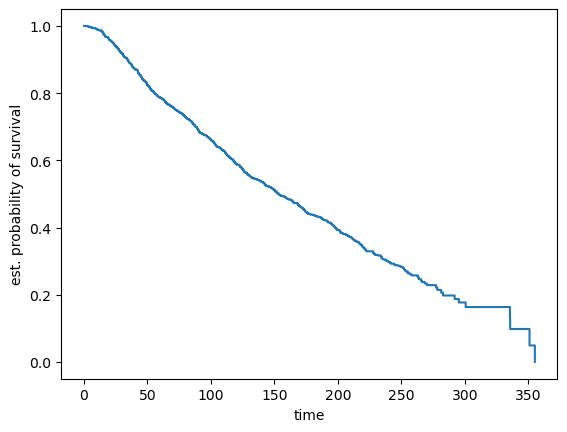

In [88]:
time, survival_prob = kaplan_meier_estimator(struct_y_train["overall_survival"], struct_y_train["overall_survival_months"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival")
plt.xlabel("time")

In [89]:
X_train["cat__integrative_cluster"].value_counts()

9.0     222
3.0     219
4.0     208
1.0     168
6.0     153
8.0     150
10.0    115
0.0     102
7.0      68
2.0      62
5.0      56
Name: cat__integrative_cluster, dtype: int64

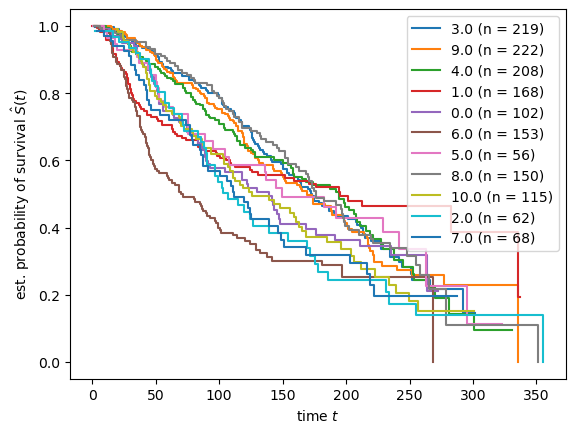

In [90]:
for value in X_train["cat__integrative_cluster"].unique():
    mask = X_train["cat__integrative_cluster"] == value
    time_grade, survival_prob_grade = kaplan_meier_estimator(struct_y_train["overall_survival"][mask],
                                                           struct_y_train["overall_survival_months"][mask])
    plt.step(time_grade, survival_prob_grade, where="post",
             label="%s (n = %d)" % (value, mask.sum()))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

Можно проводить подгрупповой анализ и сравнивать различия при помощи лог-ранкового теста, но
для того, чтобы учесть сразу все признаки, нам нужна модель пропорциональных рисков.

In [93]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 996 to 684
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   num__age_at_diagnosis                1523 non-null   float64
 1   num__chemotherapy                    1523 non-null   float64
 2   num__neoplasm_histologic_grade       1523 non-null   float64
 3   num__hormone_therapy                 1523 non-null   float64
 4   num__lymph_nodes_examined_positive   1523 non-null   float64
 5   num__mutation_count                  1523 non-null   float64
 6   num__nottingham_prognostic_index     1523 non-null   float64
 7   num__radio_therapy                   1523 non-null   float64
 8   num__tumor_size                      1523 non-null   float64
 9   num__tumor_stage                     1523 non-null   float64
 10  cat__type_of_breast_surgery          1523 non-null   float64
 11  cat__cancer_type_detailed    

In [94]:
X_train = X_train.fillna(X_train.median())

In [95]:
X_test = X_test.fillna(X_test.median())

In [96]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, struct_y_train)
CoxPHSurvivalAnalysis()

CoxPHSurvivalAnalysis()

In [98]:
pd.Series(estimator.coef_, index=X_train.columns)

num__age_at_diagnosis                  0.485499
num__chemotherapy                      0.130871
num__neoplasm_histologic_grade        -0.008600
num__hormone_therapy                   0.031980
num__lymph_nodes_examined_positive     0.070330
num__mutation_count                    0.012590
num__nottingham_prognostic_index       0.036380
num__radio_therapy                    -0.079629
num__tumor_size                        0.050466
num__tumor_stage                       0.115715
cat__type_of_breast_surgery           -0.023190
cat__cancer_type_detailed              0.098371
cat__cellularity                      -0.046094
cat__pam50_+_claudin-low_subtype      -0.034079
cat__er_status_measured_by_ihc        -0.100438
cat__er_status                        -0.599246
cat__her2_status_measured_by_snp6     -0.184157
cat__her2_status                       0.050821
cat__tumor_other_histologic_subtype   -0.108593
cat__inferred_menopausal_state         0.328219
cat__integrative_cluster              -0

In [99]:
X_train.head(5)

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype,cat__death_from_cancer
996,-0.872200,-0.512445,-0.639479,0.788547,-0.245678,-0.418388,-0.011378,-1.217538,-1.071371,0.396748,...,1.0,2.0,0.0,0.0,1.0,3.0,0.0,1.0,1.0,1.0
31,-1.094160,-0.512445,-0.639479,0.788547,-0.490841,-0.664834,-0.843407,0.821330,0.512060,0.396748,...,1.0,2.0,0.0,1.0,1.0,9.0,1.0,1.0,1.0,2.0
796,-0.529240,-0.512445,0.897956,-1.268156,-0.490841,0.074504,0.023581,0.821330,0.248155,0.396748,...,1.0,2.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
457,-0.187822,-0.512445,-0.639479,0.788547,-0.490841,-0.171942,-0.728042,0.821330,4.866498,0.396748,...,1.0,2.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,2.0
1146,-2.184693,1.951430,0.897956,0.788547,3.676928,0.074504,1.754061,0.821330,-0.411608,0.396748,...,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0


In [101]:
KM_pred = pd.DataFrame.from_dict({
    1: [1.122359, -0.512445, 0.867685, 0.788547, 1.960788, -0.169839, 1.757557, 0.821330, -0.278813, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0, 0.0],
    2: [-0.941562, 1.951430, -0.676308, 0.788547, -0.245678, -0.917810, -0.002638, -1.217538, -0.742981, 0.333732, 1.0, 4.0, 2.0, 3.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 4.0, 1.0, 1.0, 0.0, 2.0],
    3: [-1.033275, 1.951430, -0.676308, 0.788547, 0.244648, -1.167134, 0.014841, 0.821330, -0.079884, 0.333732, 1.0, 1.0, 2.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 10.0, 1.0, 1.0, 0.0, 0.0],
    4: [1.224091, 1.951430, 0.867685, 0.788547, 1.470462, -0.917810, 1.789021, 0.821330, 0.914762, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0, 0.0]},
     columns=X_test.columns, orient='index')
KM_pred



,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype,cat__death_from_cancer
1,1.122359,-0.512445,0.867685,0.788547,1.960788,-0.169839,1.757557,0.821330,-0.278813,0.333732,...,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0,0.0
2,-0.941562,1.951430,-0.676308,0.788547,-0.245678,-0.917810,-0.002638,-1.217538,-0.742981,0.333732,...,1.0,2.0,0.0,4.0,0.0,4.0,1.0,1.0,0.0,2.0
3,-1.033275,1.951430,-0.676308,0.788547,0.244648,-1.167134,0.014841,0.821330,-0.079884,0.333732,...,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0,0.0
4,1.224091,1.951430,0.867685,0.788547,1.470462,-0.917810,1.789021,0.821330,0.914762,0.333732,...,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0,0.0


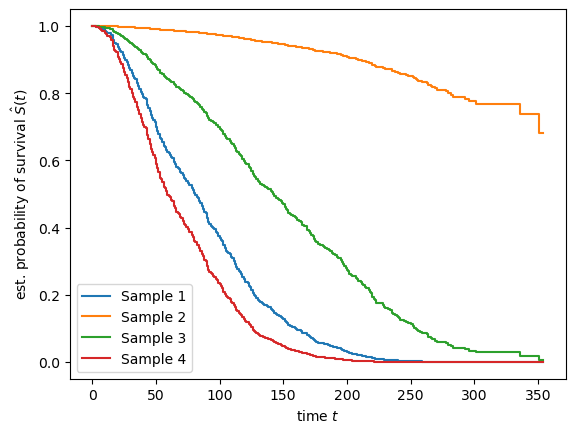

In [102]:
pred_surv = estimator.predict_survival_function(KM_pred)
time_points = np.arange(0, 355)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [103]:
#Измеряем Harrell’s concordance index or c-index.
from sksurv.metrics import concordance_index_censored

In [104]:
prediction = estimator.predict(X_test)
result = concordance_index_censored(struct_y_test["overall_survival"], struct_y_test["overall_survival_months"], prediction)
result[0]

0.8378183799350106

In [105]:
#the same
estimator.score(X_test, struct_y_test)

0.8378183799350106

In [106]:
#feature selection
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_test.values, struct_y_test)
pd.Series(scores, index=X_test.columns).sort_values(ascending=False)

cat__death_from_cancer                 0.813584
num__nottingham_prognostic_index       0.653552
num__tumor_size                        0.626544
num__lymph_nodes_examined_positive     0.619861
num__age_at_diagnosis                  0.601891
num__tumor_stage                       0.590635
cat__type_of_breast_surgery            0.569659
num__neoplasm_histologic_grade         0.569173
cat__primary_tumor_laterality          0.544821
cat__pr_status                         0.544082
num__chemotherapy                      0.538274
cat__pam50_+_claudin-low_subtype       0.537048
cat__integrative_cluster               0.536231
cat__her2_status_measured_by_snp6      0.535803
cat__er_status                         0.529537
cat__er_status_measured_by_ihc         0.529294
num__hormone_therapy                   0.522386
cat__inferred_menopausal_state         0.520256
cat__tumor_other_histologic_subtype    0.515751
num__mutation_count                    0.514720
cat__her2_status                       0

Здесь можно сказать, что модель неплохо предсказывает, но есть большие сомнения по признаку death_from_cancer (см. выше).
Попробуем его убрать и посмотрим результат.

In [107]:
X_train_24 = X_train.copy()
X_train_24.drop(['cat__death_from_cancer'], axis=1, inplace=True)
X_test_24 = X_test.copy()
X_test_24.drop(['cat__death_from_cancer'], axis=1, inplace=True)

In [108]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train_24, struct_y_train)
CoxPHSurvivalAnalysis()

CoxPHSurvivalAnalysis()

In [109]:
pd.Series(estimator.coef_, index=X_train_24.columns)

num__age_at_diagnosis                  0.616873
num__chemotherapy                      0.103034
num__neoplasm_histologic_grade         0.012524
num__hormone_therapy                  -0.032384
num__lymph_nodes_examined_positive     0.166757
num__mutation_count                    0.005315
num__nottingham_prognostic_index       0.122917
num__radio_therapy                    -0.123152
num__tumor_size                        0.100879
num__tumor_stage                       0.123945
cat__type_of_breast_surgery            0.062720
cat__cancer_type_detailed              0.144746
cat__cellularity                      -0.001466
cat__pam50_+_claudin-low_subtype       0.006389
cat__er_status_measured_by_ihc        -0.016720
cat__er_status                        -0.380466
cat__her2_status_measured_by_snp6     -0.073717
cat__her2_status                       0.407796
cat__tumor_other_histologic_subtype   -0.092564
cat__inferred_menopausal_state         0.418152
cat__integrative_cluster               0

In [110]:
KM_pred_24 = pd.DataFrame.from_dict({
    1: [1.122359, -0.512445, 0.867685, 0.788547, 1.960788, -0.169839, 1.757557, 0.821330, -0.278813, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0],
    2: [-0.941562, 1.951430, -0.676308, 0.788547, -0.245678, -0.917810, -0.002638, -1.217538, -0.742981, 0.333732, 1.0, 4.0, 2.0, 3.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 4.0, 1.0, 1.0, 0.0],
    3: [-1.033275, 1.951430, -0.676308, 0.788547, 0.244648, -1.167134, 0.014841, 0.821330, -0.079884, 0.333732, 1.0, 1.0, 2.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 10.0, 1.0, 1.0, 0.0],
    4: [1.224091, 1.951430, 0.867685, 0.788547, 1.470462, -0.917810, 1.789021, 0.821330, 0.914762, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0]},
     columns=X_test_24.columns, orient='index')
KM_pred_24


,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype
1,1.122359,-0.512445,0.867685,0.788547,1.960788,-0.169839,1.757557,0.821330,-0.278813,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0
2,-0.941562,1.951430,-0.676308,0.788547,-0.245678,-0.917810,-0.002638,-1.217538,-0.742981,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,4.0,1.0,1.0,0.0
3,-1.033275,1.951430,-0.676308,0.788547,0.244648,-1.167134,0.014841,0.821330,-0.079884,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0
4,1.224091,1.951430,0.867685,0.788547,1.470462,-0.917810,1.789021,0.821330,0.914762,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0


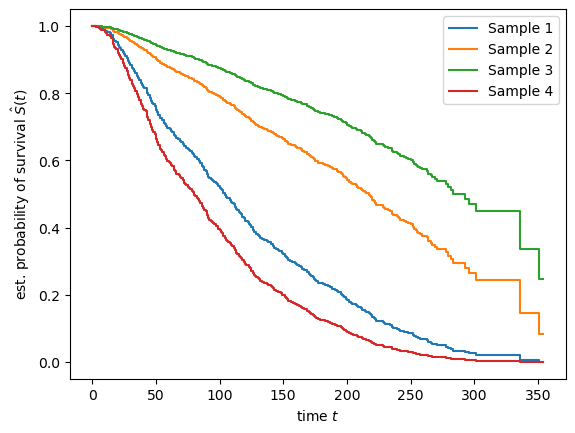

In [111]:
pred_surv = estimator.predict_survival_function(KM_pred_24)
time_points = np.arange(0, 355)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [112]:
prediction = estimator.predict(X_test_24)
result = concordance_index_censored(struct_y_test["overall_survival"], struct_y_test["overall_survival_months"], prediction)
result[0]

0.6898215710310742

что и требовалось доказать...

Выберем лучшие признаки

In [128]:
X_pandas = X_pandas.fillna(X_pandas.median())

In [146]:
X_pandas_24 = X_pandas.copy()
X_pandas_24.drop(['cat__death_from_cancer'], axis=1, inplace=True)

In [132]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])
                 

In [147]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, X_pandas_24.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_pandas_24, struct_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
19,20,{'select__k': 20},0.702306,0.671426,0.656342,0.676691,0.019131,1,0.678388,0.682688,0.687324,0.682800,0.003649
20,21,{'select__k': 21},0.700333,0.672582,0.656898,0.676604,0.017959,2,0.677759,0.683355,0.687284,0.682799,0.003908
23,24,{'select__k': 24},0.698985,0.670510,0.659970,0.676489,0.016479,3,0.679646,0.685026,0.690317,0.684997,0.004357
22,23,{'select__k': 23},0.700473,0.671312,0.656606,0.676130,0.018230,4,0.679344,0.683129,0.688883,0.683785,0.003922
21,22,{'select__k': 22},0.700576,0.671007,0.656741,0.676108,0.018255,5,0.677945,0.683641,0.686766,0.682784,0.003652
18,19,{'select__k': 19},0.700554,0.671426,0.655208,0.675729,0.018761,6,0.677229,0.682556,0.686364,0.682050,0.003746
17,18,{'select__k': 18},0.700679,0.669304,0.654980,0.674988,0.019084,7,0.677167,0.682471,0.685999,0.681879,0.003630
16,17,{'select__k': 17},0.699059,0.667303,0.654994,0.673785,0.018564,8,0.673583,0.681933,0.685969,0.680495,0.005158
15,16,{'select__k': 16},0.698823,0.667885,0.654431,0.673713,0.018586,9,0.673586,0.682112,0.685835,0.680511,0.005127
13,14,{'select__k': 14},0.700333,0.664521,0.651936,0.672263,0.020502,10,0.669485,0.680081,0.686622,0.678729,0.007061


In [151]:
pipe.set_params(**gcv.best_params_)
pipe.fit(X_pandas_24, struct_y)

transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=[transformer.get_support()])

ValueError: Length of values (20) does not match length of index (24)

Попробуем гребневую регрессию?? (Penalized Cox Model), которая позволяет улучшить результаты при большом количестве признаков

In [148]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(12, 10))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [149]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train_24, struct_y_train)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(X_train_24.columns))

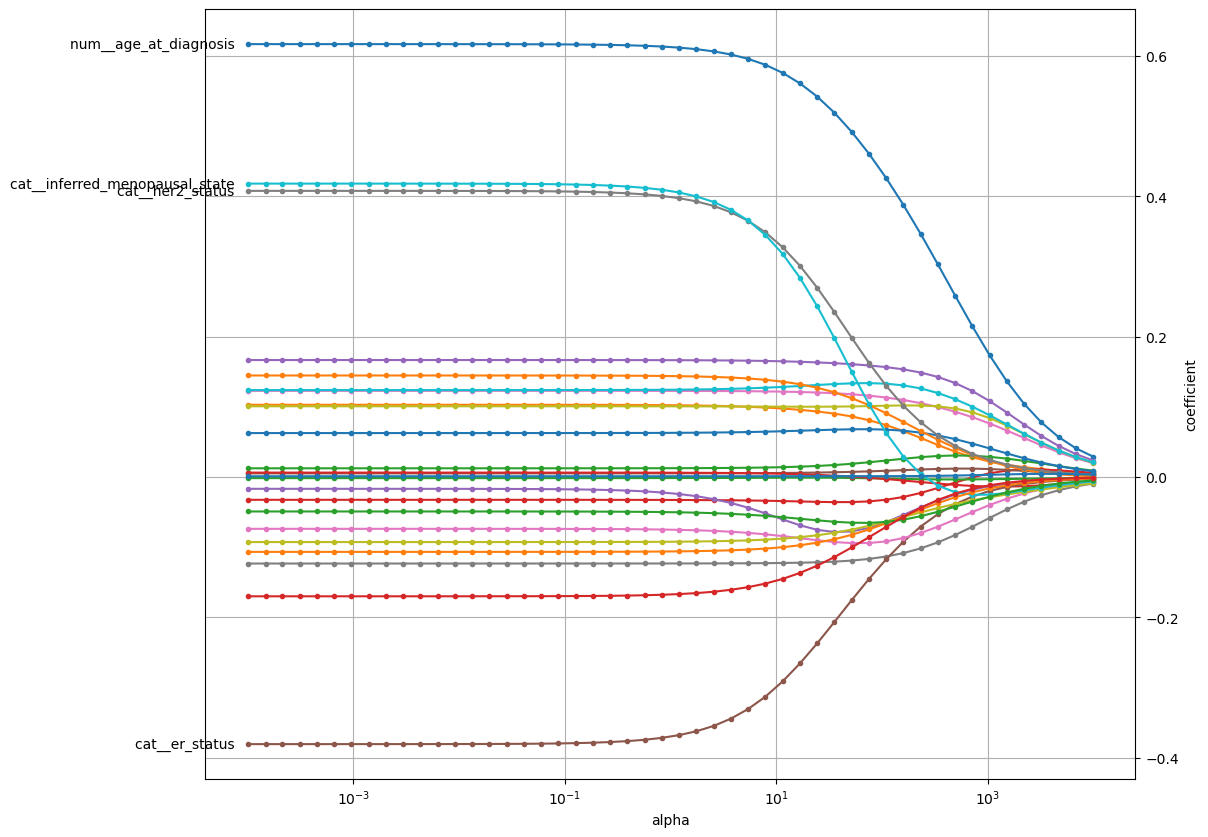

In [150]:
plot_coefficients(coefficients, n_highlight=4)